# Extending existing models (with a side-order of XSPEC)

I was recently asked by a colleage whether Sherpa allowed you to subtract a model. This is "easy" - since you can create model expressions using `+`, `-`, `*`, and `/` - but it turned out that what was really wanted fitted into my current documentation obsession, writing user models in Sherpa. It also lets me play Sherpa's support for
[XSPEC models](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/Models.html).

The aim of this notebook is to show you how you can write models in Sherpa that use existing Sherpa models. In this particular case I will create a model that is the result of subtracting two XSPEC `vvnei` models, providing an interface where the Hydrogen abundance is no-longer a parameter (I make no claim that this is a physically-meaningful model), but the approach is valid for all Sherpa models. The notebook ends up with a brief discussion about optimising model, but this is meant more as a primer on the subject than an in-depth discussion.

I am going to assume that you have read at least
[Writing your own user model](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/user%20model.ipynb)
but please feel free to look through
[all the notebooks](https://github.com/DougBurke/sherpa-standalone-notebooks)
I've written in the series.

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on June 16 2015. This notebook, and others that may be of
interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra
X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository
if you have any questions. 

## Last run

When was this notebook last run?

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2025-10-07 17:01'

and with what version of Sherpa?

In [2]:
import sherpa
sherpa._version.get_versions()

{'date': '2025-09-29T09:22:24-0400',
 'dirty': False,
 'error': None,
 'full-revisionid': '5317ba1bd9c20c5d482e399cdac71d8eb7fde83b',
 'version': '4.18.0'}

## Setting up for XSPEC

If you are using the Sherpa provided with
[CIAO](http://cxc.harvard.edu/ciao/) then you can skip this section, as the XSPEC extension
is provided for you (**note** if you are using the "binder" version to view the notebooks
then you are fine, since it is packaged with CIAO 4.14).

If you are using the standalone version of Sherpa, then you need to have the XSPEC libraries and then tell Sherpa where they are, before building Sherpa. I used to have documentation here about what needed to be done, but we now have a shiny web site describing 
[how to install Sherpa](https://sherpa.readthedocs.io/en/4.14.0/install.html), including 
[building Sherpa with XSPEC support](https://sherpa.readthedocs.io/en/4.14.0/install.html#xspec).

## Loading the XSPEC models

The XSPEC models are automatically loaded - if available - by the `sherpa.astro.ui` module, but here I am also going to load in the [`sherpa.astro.xspec`](https://sherpa.readthedocs.io/en/4.11.0/model_classes/xspec_model.html) module so that I can access several
low-level routines (i.e. ones we don't provide access to from `sherpa.astro.ui`):

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from sherpa.astro import ui
from sherpa.astro import xspec

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [4]:
%matplotlib inline

To check that things are working, we can find out the version of the XSPEC library in use (it's important to compare this to the 
[XSPEC issues list](https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/issues/issues.html)):

In [5]:
xspec.get_xsversion()

'12.15.0d'

If this command fails with the message

```
ImportError: XSPEC initialization failed; check HEADAS environment variable
```

then check that this variable is set correctly. It should be set to the parent directory
of the `lib` directory used for the `xspec_lib_dirs` setting used to build Sherpa. For example

```
import os
os.environ['HEADAS'] = '/usr/local/headas-6.16/x86_64-unknown-linux-gnu-libc2.21-0/'
```

and then - assuming this *is* the correct setting ;-) - then the `xspec.get_xsversion()` command should work.

In [6]:
xspec.get_xschatter()

10

The XSPEC chatter level - which can be read with `xspec.get_xschatter` and set with `xspec.set_xschatter` can be used to change the amount of output printed to the screen when X-Spec models are evaluated. The default value used by Sherpa, **as of the 4.14 release** - is `10`, which matches the XSPEC default. If you want no outout, set it to `0` and `25` can be helpful for debugging (e.g. to check that data files are being read correctly; although the amount of information provided depends on the model and the version of XSPEC in use).

With the release of XSPEC 12.15.1 (which Sherpa 4.18.0 unfortunately does not support) there have been changes to how the APEC/ATOMDB versions get set. This can lead to issues with being unable to understand what the "`latest`" version is, so for now we explicitly state the version to use (this will depend on what version of XSPEC you have installed and what data you have available):

In [7]:
xspec.set_xsxset("APECROOT", "3.1.3")
xspec.set_xsxset("NEIAPECROOT", "3.1.3")

## The model

The model I am going to develop is a version of the 
[`vvnei` model](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelNei.html) - which
is a non-equilibrium ionisation model with variable abundances - which has no Hydrogen. The
standard way for XSPEC to model variable abundances is to make them all relative to Hydrogen, but in this case we (or at least, my colleague), does not want any Hydrogren! One solution for this is to evaluate the model twice, once with a Hydrogen abundance of 1, and the required elemental abundances, and then a Hydrogen-only version. The second version is subtracted from the first (hence the original question I was asked) to return the required model.

This can be done directly in Sherpa, using two different instances of the `xsvvnei` model,
but we can also write our own user model to wrap up this behavior, and provide a slightly-simpler interface to the user.

Before we write the user model, let's try and see the individual components. The following creates two instances of the `vvnei` model (Sherpa prepends `xs` to the XSPEC model names), called `mdl_with_elems` and `mdl_h_only`. I then set several of the elemental abundances in the `mdl_with_elems` component - using `ui.set_par` - and then clear out all the non-Hydrogen abundances in the `mdl_h_only` component (I happen to know that the check I wrote is sufficient *for this model type* to select only the abundances I wanted to change). This code shows two different ways of accessing model parameters (by name, with `ui.set_par`, or by iterating directly from the model component), but I don't want to talk too much about this today:

In [8]:
ui.xsvvnei.mdl_with_elems
ui.xsvvnei.mdl_h_only

# Set some abundances
abunds = { 'c': 2.3, 'fe': 1.8, 'o': 3.4, 'si': 2.1, 'ar': 1.2 }
for (k, v) in abunds.items():
    ui.set_par('mdl_with_elems.' + k, v)
    
# Clear out the abundances for the Hydrogen-only version
for p in mdl_h_only.pars:
    if len(p.name) < 3 and p.name not in ['kT', 'H']:
        p.val = 0

This particular model has a lot of parameters!

In [9]:
mdl_with_elems

<XSvvnei model instance 'xsvvnei.mdl_with_elems'>

We can see that the 'Hydrogen only' one has been cleared out:

In [10]:
mdl_h_only

<XSvvnei model instance 'xsvvnei.mdl_h_only'>

The models can be evaluated on the grid 0.1 to 10 keV, with bin spacing 0.01 keV (XSPEC models expect the input grid to be in keV). The line emission from the elements is visible here:

Reading NEI APEC spectral data from 3.1.3



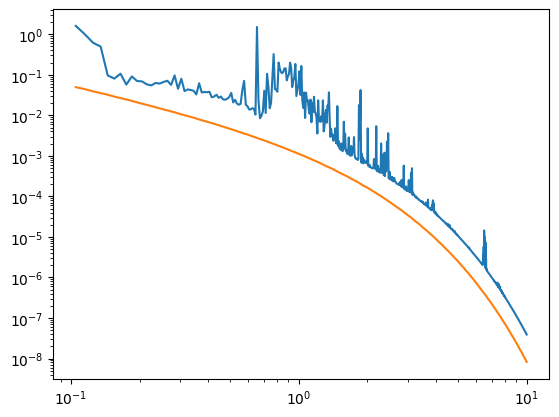

In [11]:
egrid = np.arange(0.1, 10, 0.01)
elo = egrid[:-1]
ehi = egrid[1:]
emid = (elo + ehi) / 2

plt.plot(emid, mdl_with_elems(elo, ehi))
plt.plot(emid, mdl_h_only(elo, ehi))
plt.yscale('log')
plt.xscale('log')

Subtracting these two will give the elemental emission for a situation where there is no Hydrogen. I also convert the plot values into those more commonly displayed: the XSPEC models return the flux in units of photon/cm^2/s for each bin, so we need to divide by the bin width to get the flux density.

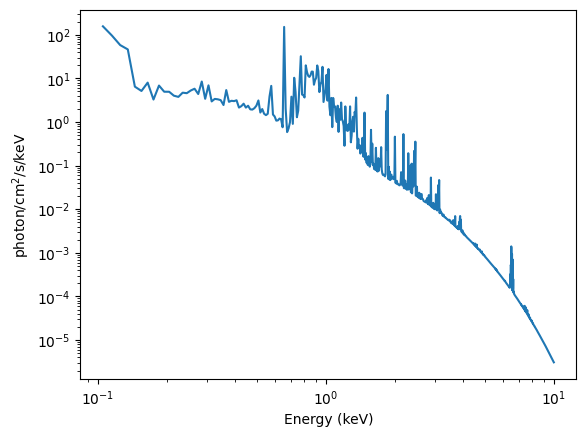

In [12]:
de = ehi - elo
y = mdl_with_elems(elo, ehi) - mdl_h_only(elo, ehi) 
plt.plot(emid, y / de)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('photon/cm$^2$/s/keV');

### Aside

In previous versions of this notebook I used a "special" way to evaluate XSPEC models by only providing a single array. This is **not a good idea**™ so I've gone to
providing both low- and high- values for the grid.

### End aside

## Using the existing models

Since we can write model expressions using subtraction, then the "Hydrogen free" variant of `xsvvnei` could be handled explicitly, by using the model combination

    (ui.xsvvnei.mdl_elems - ui.xsvvnei.mdl_honly)
    
in the source expression. It then requires

 - linking the `kT`, `Tau`, `redshift`, and `norm` parameters: for example
 
        ui.link(mdl_honly.kt, mdl_elems.kt)
        ui.link(mdl_honly.tau, mdl_elems.tau)
        ui.link(mdl_honly.redshift, mdl_elems.redshift)
        ui.link(mdl_honly.norm, mdl_elems.norm)
        
 - setting the `mdl_honly` elemental abundances to 0:
 
        for p in mdl_honly.pars:
            if p.name.lower() not in ['kt', 'h', 'tau', redshift', 'norm']:
                p.val = 0
                p.frozen = True # this is actually the default, but just check
                
 - fixing the Hydrogen abundances
 
        mdl_honly.h = 1
        mdl_elems.h = 1
        ui.freeze(mdl_honly.h, mdl_elems.h)

 - thaw the elemental abundances in `mdl_elems` that you want to fit.
 
This can be done, but if you started using this model a lot, you'd quickly find it annoying (and
easy to miss a step). What is needed is a way to create a user model - as described in
[previous notebooks](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/user%20model.ipynb) - but 
instead of writing the function, use the existing Sherpa code to evaluate the models.

## Writing a simple user model

So, can we simplify the above by writing a simple user model? First of all, let's look at evaluating the model for a given set of parameters. The evaluations above have required an instance of the model - which I created by calling

    ui.xsvvnei.mdl_with_elems
    
but could have also used

    ui.create_model_component('xsvvnei', 'mdl_with_elems')
    
I could use this approach in a user model, but it would involve coming up with unique model names which is messy and inelegant. What I really want to be able to do is evaluate the model
without creating a component. This can be done by using parts of Sherpa directly. In this case, the models are defined in the `sherpa.astro.xspec` module, and we can create an object directly:

In [13]:
mdl = xspec.XSvvnei()

The model can be given a name by sending in a string to the constructor, but this is only used in screen output which we do not care about, so we let the default value be used. The only real difference to calling this, rather than `ui.create_model_component` (or writing `ui.xsvvnei.xxx`), is that this model is not added to the Sherpa session, so it does not conflict with anything (e.g. `ui.list_model_components()` will not include it). This makes it ideal for our purposes, since it is essentially an anonymous model.

An anonymous model function is a start, but I also need an easy way to call the model with different parameters: one set with the elemental abundances, and the second time with Hydrogen only. I *could* set one set of parameters, evaluate the model, and then swap in the second set and re-evaluate. However, the Sherpa model class defines the `calc` method, which has the signature:

In [14]:
help(mdl.calc)

Help on method calc in module sherpa.astro.xspec:

calc(p, *args, **kwargs) method of sherpa.astro.xspec.XSvvnei instance
    Calculate the model given the parameters and grid.

    Notes
    -----
    XSPEC models must always be evaluated with low and high bin
    edges. Although supported by the XSPEC model interface the
    ability to evaluate using an XSPEC-style grid (n+1 values for
    n bins which we pad with a 0), we do not allow this here since
    it complicates the handling of the regrid method.

    Keyword arguments are ignored.



The `pars` argument is the array of parameter values (in the order displayed from `print(mdl)` or returned by `mdl.pars`) and the remaining arguments are the independent axes on which to evaluate the model. This is therefore the second part to writing the user model.

Since the interface to the models can change over time, let's check the number of parameters (it is unlikely to change for this particular model):

In [15]:
print(f"Length of pars = {len(mdl.pars)}")

# filter out H, tau, redshift, norm
fpars = [p for p in mdl.pars if p.name.lower() not in ['h', 'tau', 'redshift', 'norm']]
print(f" filtered pars = {len(fpars)}")

Length of pars = 34
 filtered pars = 30


If I wanted the following to be robust I'd actually check the parameter names and orders, but for this
notebook I am just going to index directly into the parameter array of `XSvvnei`:

In [16]:
def xsvvnei_no_h(pars, *args):
    "pars is kT, list of 29 element abundances (excluding H), tau, redshift, norm"

    # It's a bit excessive to create this each iteration
    mdl = xspec.XSvvnei()
    
    pall = [pars[0], 1.0]
    pall.extend(pars[1:])
    
    phonly = [pars[0], 1.0]
    phonly.extend([0.0] * 29)
    phonly.extend(pars[-3:])

    # Evaluate the "Hydrogen-free" model
    return mdl.calc(pall, *args) - mdl.calc(phonly, *args)

As a check, does this give the same answer as evaluating the separate models?

In [17]:
pars = [p.val for p in mdl_with_elems.pars if p.name != "H"]
ynew = xsvvnei_no_h(pars, elo, ehi)
y = mdl_with_elems(elo, ehi) - mdl_h_only(elo, ehi) 
np.all(ynew == y)

np.True_

This can be added to Sherpa using `ui.load_user_model` to create a model instance (i.e. component). Since I want to copy over the parameter settings from the `xsvvnei` model
(at least, apart from for `H`), I have written a small function that both loads the 
model - with `ui.load_user_model` - and sets the parameter values - with `ui.add_user_pars`:

In [18]:
def make_xsvvnei_noh_model(name):
    """Create an instance of the 'xsvvnei' model which has
    no Hydrogen."""
    
    # Create the model instance
    ui.load_user_model(xsvvnei_no_h, name)
    
    # Get a copy of the default parameter settings for the vvnei
    # model (excluding Hydrogen).
    pars = [p for p in xspec.XSvvnei().pars if p.name != 'H']
    
    parnames = [p.name for p in pars]
    parvals = [p.val for p in pars]
    parmins = [p.min for p in pars]
    parmaxs = [p.max for p in pars]
    parunits = [p.units for p in pars]
    parf = [p.frozen for p in pars]
    
    # Set up the parameters for this instance
    ui.add_user_pars(name, parnames, parvals=parvals, parmins=parvals,
                     parmaxs=parmaxs, parunits=parunits, parfrozen=parf)
    
    # Return the model
    return ui.get_model_component(name)

In [19]:
make_xsvvnei_noh_model('noh')

<UserModel model instance 'usermodel.noh'>

In [20]:
print(noh)

usermodel.noh
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   noh.kT       thawed            1            1         79.9        keV
   noh.He       frozen            1            1         1000           
   noh.Li       frozen            1            1         1000           
   noh.Be       frozen            1            1         1000           
   noh.B        frozen            1            1         1000           
   noh.C        frozen            1            1         1000           
   noh.N        frozen            1            1         1000           
   noh.O        frozen            1            1         1000           
   noh.F        frozen            1            1         1000           
   noh.Ne       frozen            1            1         1000           
   noh.Na       frozen            1            1         1000           
   noh.Mg       frozen            1  

A quick check shows how the Oxygen abundance changes the results for
the default temperature:

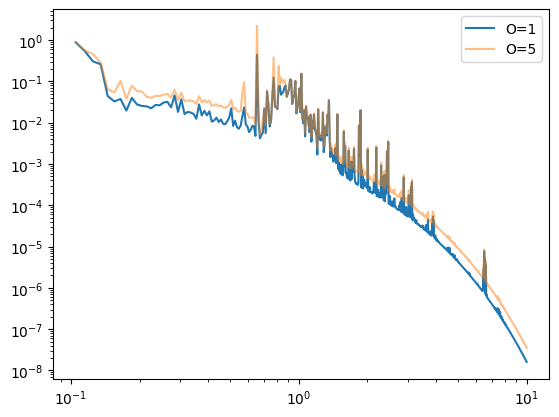

In [21]:
yo1 = noh(elo, ehi)

noh.o = 5
yo5 = noh(elo, ehi)

plt.plot(emid, yo1, label='O=1')
plt.xscale('log')
plt.yscale('log')

plt.plot(emid, yo5, alpha=0.5, label='O=5')
plt.legend();

This (XSPEC 12.8-ish ere) used to be a more-obvious difference, but changes to the models have reduced the visual impact. So let's try subtracting them:

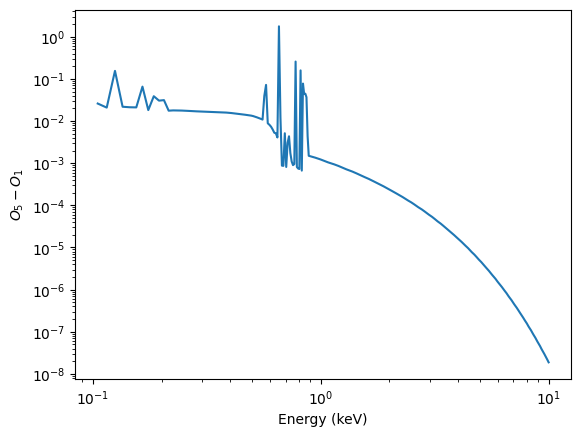

In [22]:
plt.plot(emid, yo5 - yo1)
plt.xlabel('Energy (keV)')
plt.ylabel(r'$O_5 - O_1$')
plt.xscale('log')
plt.yscale('log');

or try looking at the ratio:

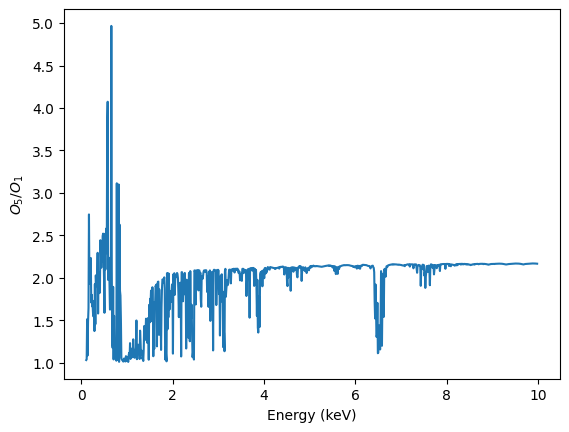

In [23]:
plt.plot(emid, yo5 / yo1)
plt.xlabel('Energy (keV)')
plt.ylabel(r'$O_5 / O_1$');

## Using a class-based approach

As with the
['User models in Sherpa' notebook](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/user%20model.ipynb),
we can also create a class for this model:

In [24]:
from sherpa.models import model

class XSvvneiNoH(model.ArithmeticModel):
    """A version of XSvvnei which has no Hydrogen. The
    abundances of the other elements are given relative to
    solar abundance of Hydrogen.
    """
    
    def __init__(self, name='xxvvneinoh'):
        mdl = xspec.XSvvnei()
        
        pars = []
        for par in mdl.pars:
            if par.name == 'H':
                continue
                
            newpar = model.Parameter(name, par.name, par.val, min=par.min, max=par.max,
                                     hard_min=par.hard_min, hard_max=par.hard_max,
                                     units=par.units, frozen=par.frozen,
                                     alwaysfrozen=par.alwaysfrozen, hidden=par.hidden)
            setattr(self, par.name, newpar)
            pars.append(newpar)
            
        model.ArithmeticModel.__init__(self, name, tuple(pars))
        
    @model.modelCacher1d
    def calc(self, pars, x, *args, **kwargs):
        return xsvvnei_no_h(pars, x, *args)

# Tell Sherpa about the model
ui.add_model(XSvvneiNoH)

This class can then be used to create model components: in the following I show the lines from Carbon, Oxygen, and Argon lines.

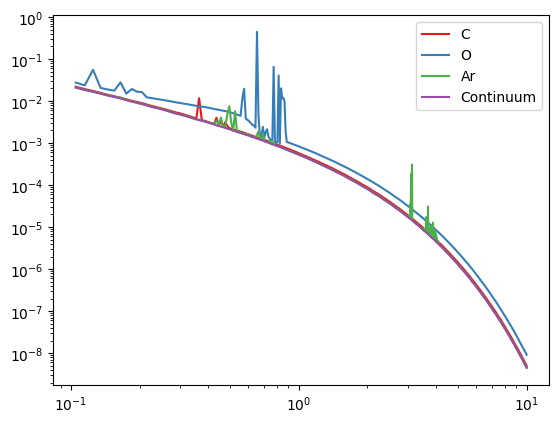

In [25]:
ui.create_model_component('xsvvneinoh', 'mdl')

# Clear out all the elemental abundances
for par in mdl.pars:
    if len(par.name) < 3 and par.name != 'kT':
        par.val = 0

# Colors are taken from ColorBrewer2, or rather,
# this StackOverflow answer: http://stats.stackexchange.com/a/118183
        
# Ensure there's some continuum
mdl.he = 1

# Carbon
mdl.c = 1
plt.plot(emid, mdl(elo, ehi), c='#e41a1c', label='C')

# Oxygen
mdl.c = 0
mdl.o = 1
plt.plot(emid, mdl(elo, ehi), c='#377eb8', label='O')

# Argon
mdl.o = 0
mdl.ar = 1
plt.plot(emid, mdl(elo, ehi), c='#4daf4a', label='Ar')

# Continuum
mdl.ar = 0
plt.plot(emid, mdl(elo, ehi), c='#984ea3', label='Continuum')

plt.legend()
plt.xscale('log')
plt.yscale('log')

## Can we make this faster?

**NOTE**

This section has been updated to

1. match changes made to how XSPEC additive models are internally handled in the `4.18.0` release
2. turn off the model cache to make the timing checks more valid (but care still needs to be taken in the interpretation).

---

If I were to be using this for actual analysis, I would probably re-write `xsvvnei_no_h` so that it is sent the model instance to use, rather than re-create it each time the model is evaluated, since the latter feels wasteful. However, it is *really* important to actually measure the time these functions take to run to make sure changes you make are worth it,
so I'll do that too.

In [26]:
# I repeat the original version as a reference.
def xsvvnei_no_h_1(pars, *args):
    "pars is kT, list of 29 element abundances (excluding H), tau, redshift, norm"

    # It's a bit excessive to create this each iteration
    mdl = xspec.XSvvnei()
    
    pall = [pars[0], 1.0]
    pall.extend(pars[1:])
    
    phonly = [pars[0], 1.0]
    phonly.extend([0.0] * 29)
    phonly.extend(pars[-3:])

    # Turn off the cache for this test
    mdl.cache = 0
    
    # Evaluate the "Hydrogen-free" model
    return mdl.calc(pall, *args) - mdl.calc(phonly, *args)

# This version requires a model instance to be sent in
def xsvvnei_no_h_2(mdl, pars, *args):
    "pars is kT, list of 29 element abundances (excluding H), tau, redshift, norm"

    pall = [pars[0], 1.0]
    pall.extend(pars[1:])
    
    phonly = [pars[0], 1.0]
    phonly.extend([0.0] * 29)
    phonly.extend(pars[-3:])

    # Evaluate the "Hydrogen-free" model
    return mdl.calc(pall, *args) - mdl.calc(phonly, *args)    

The IPython interpreter provides the 
[`%timeit`](http://ipython.org/ipython-doc/stable/interactive/magics.html#magic-timeit)
command, which is a basic - *but useful*, as I'll show - way to time functions. In this case,
I want to evaluate the two functions, which means I need a parameter array, a model (for `xsvvnei_no_h_2`), and I'll use `egrid` for the grid.

In [27]:
pars = [p.val for p in mdl.pars]
mdl_2 = xspec.XSvvnei()

In [28]:
# Ensure the cache is turned off
mdl_2.cache = 0

The `%timeit` command takes the function to evaluate, and runs it multiple times, and reports its best estimate for the run time (it's an adaptive scheme, in that it tailors the number of loops to how long the function takes, and reports the time taken in "sensible" units).

In [29]:
%timeit xsvvnei_no_h_1(pars, elo, ehi)

13.6 ms ± 29.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit xsvvnei_no_h_2(mdl_2, pars, elo, ehi)

13.3 ms ± 47.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we can see in this example, the second function is significantly faster than the first one (which surprised me, and the speed-up depends on the version of Sherpa being used). Now, there's **plenty of things**
to be wary of when using this, since

 - I have not actualy checked that the two functions return the same values (which you
   really *must do* before trying to work out which is faster);
   
 - it relies on the function always doing the same amount of work each iteration
   (it might be that the function loads in data files for particular parameter values,
   or sets up memory or loads in data the first time it is run);
   
 - I have only used a single set of parameters and one energy grid and the difference in 
   run time could well vary depending on these values;
   
 - when used in a fit, there is plenty of other code being run, so there comes a point
   at which reducing the run time of a model component is no longer worth it (perhaps
   there's another model being evaluated which is significantly slower).

So, this is a start, but it's not the end of the story. There are other commands and
modules in Python that can help you optimise the run time (or memory usage), of Python
code (e.g. 
[Timing and Profiling](http://pynash.org/2013/03/06/timing-and-profiling.html),
[SciPy notes on Optimizing code](http://scipy-lectures.github.io/advanced/optimizing/),
[Jake VanderPlas' example of optimizing Python code](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/),
[SnakeViz for visualizing the cProfile output](https://jiffyclub.github.io/snakeviz/),
and plenty of other resources out there on the internet).

## Just one more thing

The code above uses the generic Sherpa model interface to evaluate a model; that is, it uses the `calc` method of the `Model` class to evaluate the model, and can be used for *all* Sherpa models. I happen to know that$^\dagger$,
for XSPEC models, this method is defined as

```
class XSModel(ArithmeticModel):
    
    @modelCacher1d
    def calc(self, *args, **kwargs):
        return self._calc(*args, **kwargs)
```

and that the `XSvvnei` class defines `_calc` to be:

```
class XSvvnei(XSAdditiveModel):

    _calc =  _xspec.C_vvnei
...
```

---

$^\dagger$ - actually, it used to be implemented like this circa version 4.9, but in order to better support different versions the XSPEC model library, we now use a slightly-more complicated scheme, but the *essence* is the same, that is there is a field in the class structure that contains the actual function from the XSPEC model library that we can call.

---

The `4.18.0` release has chanhed how the attitive models (those that derive from `XSAdditiveModel`) handle the normalization. The `_calc` method is now sent all the parameters **except** for the `norm` parameter (which matches how XSPEC calls these models), which means that the code below needs to change slightly/

---

This means that we can call `_calc` instead of `calc`, saving even-more time. Let's see
how much this really helps:

In [31]:
from sherpa.astro.xspec import _xspec

def xsvvnei_no_h_3(mdl, pars, *args):
    "pars is kT, list of 29 element abundances (excluding H), tau, redshift, norm"

    # Drop the normalization
    pall = [pars[0], 1.0]
    pall.extend(pars[1:-1])
    
    phonly = [pars[0], 1.0]
    phonly.extend([0.0] * 29)
    phonly.extend(pars[-3:-1])

    # Evaluate the "Hydrogen-free" model, correcting for the norm parameter.
    return pars[-1] * (mdl._calc(pall, *args) - mdl._calc(phonly, *args))

def xsvvnei_no_h_4(pars, *args):
    "pars is kT, list of 29 element abundances (excluding H), tau, redshift, norm"

    # Drop the normalization
    pall = [pars[0], 1.0]
    pall.extend(pars[1:-1])
    
    phonly = [pars[0], 1.0]
    phonly.extend([0.0] * 29)
    phonly.extend(pars[-3:-1])

    # Evaluate the "Hydrogen-free" model, correcting for the norm parameter.
    # The direct methods - like _xspec.C_vvnei - are not cached.
    return pars[-1] * (_xspec.C_vvnei(pall, *args) - _xspec.C_vvnei(phonly, *args))    

In [32]:
%timeit xsvvnei_no_h_1(pars, elo, ehi)
%timeit xsvvnei_no_h_2(mdl_2, pars, elo, ehi)
%timeit xsvvnei_no_h_3(mdl_2, pars, elo, ehi)
%timeit xsvvnei_no_h_4(pars, elo, ehi)

13.6 ms ± 32 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.2 ms ± 35 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.2 ms ± 40.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.2 ms ± 41.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So, in this case, the extra "optimisations" do not appear to save us time. However, as already mentioned, this is a trickybusiness to get right.